In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import load_model
import joblib
import pickle

# Load AIS data with extracted features
vessel_data = pd.read_csv('Generated_csv\\vessel_data_with_features.csv')

def moving_avg_anomaly_detection(df, column, window=5, threshold=2):
    """
    Detect anomalies based on moving average for a given column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column (str): The column name for which to calculate the moving average and detect anomalies.
    - window (int): The window size for the moving average. Default is 5.
    - threshold (float): The number of standard deviations away from the moving average that will be considered an anomaly. Default is 2.
    
    Returns:
    - pd.DataFrame: The DataFrame with additional columns for moving average and anomalies.
    """
    # Calculate moving average
    moving_avg_column = f'{column}_moving_avg'
    df[moving_avg_column] = df[column].rolling(window=window).mean()
    
    # Calculate anomalies based on deviations from the moving average
    anomaly_column = f'{column}_anomaly_moving_avg'
    df[anomaly_column] = np.abs(df[column] - df[moving_avg_column]) > threshold * df[column].std()
    
    return df
### Kalman Filter ###
from pykalman import KalmanFilter

def kalman_filter_anomaly_detection(df, column):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    state_means, state_covariances = kf.em(df[column].values).filter(df[column].values)
    df[f'{column}_kalman'] = state_means
    df[f'{column}_anomaly_kalman'] = np.abs(df[column] - df[f'{column}_kalman']) > 2 * df[column].std()
    # Save the filter parameters
    with open(f'{column}_kalman_filter.pkl', 'wb') as f:
        pickle.dump(kf, f)
    return df

# Apply Kalman Filter for SOG
vessel_data = kalman_filter_anomaly_detection(vessel_data, 'SOG')

### DBSCAN ###
def dbscan_anomaly_detection(df, features, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(features)
    df['anomaly_dbscan'] = df['cluster'] == -1
    # Save DBSCAN model parameters
    with open('dbscan_model.pkl', 'wb') as f:
        pickle.dump(dbscan, f)
    return df

# Apply DBSCAN
features = vessel_data[['SOG', 'COG', 'LAT', 'LON']].values
vessel_data = dbscan_anomaly_detection(vessel_data, features)

### Isolation Forest ###
def isolation_forest_anomaly_detection(df, features, contamination=0.01):
    clf = IsolationForest(contamination=contamination)
    df['anomaly_isolation_forest'] = clf.fit_predict(features) == -1
    # Save Isolation Forest model
    joblib.dump(clf, 'isolation_forest_model.joblib')
    return df

# Apply Isolation Forest
vessel_data = isolation_forest_anomaly_detection(vessel_data, features)

### Autoencoder ###
def autoencoder_anomaly_detection(df, features, encoding_dim=2, epochs=50, batch_size=32):
    input_dim = features.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='linear')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Normalize features
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    features_norm = (features - mean) / std
    
    # Train the autoencoder
    autoencoder.fit(features_norm, features_norm, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.1)
    
    # Save the autoencoder model
    autoencoder.save('autoencoder_model.h5')
    
    # Calculate reconstruction error
    reconstructions = autoencoder.predict(features_norm)
    mse = np.mean(np.power(features_norm - reconstructions, 2), axis=1)
    df['anomaly_autoencoder'] = mse > np.percentile(mse, 95)
    return df

# Apply Autoencoder
vessel_data = autoencoder_anomaly_detection(vessel_data, features)



Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4708 - val_loss: 0.7766
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9858 - val_loss: 0.5886
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7284 - val_loss: 0.3940
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5744 - val_loss: 0.3176
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4624 - val_loss: 0.3126
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4086 - val_loss: 0.3144
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3772 - val_loss: 0.3289
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3543 - val_loss: 0.3398
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3353 - val_loss: 0.3458
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3146 - val_loss: 0.3546
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3069 - val_loss: 0.3784
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


In [9]:
# Moving Average Anomaly Detection Function

def moving_avg_anomaly_detection(df, column, window=5, threshold=2):
    moving_avg_column = f'{column}_moving_avg'
    anomaly_column = f'{column}_anomaly_moving_avg'
    
    # Calculate moving average
    df[moving_avg_column] = df[column].rolling(window=window).mean()
    
    # Calculate anomalies based on deviations from the moving average
    df[anomaly_column] = np.abs(df[column] - df[moving_avg_column]) > threshold * df[column].std()
    
    return df

# Example z-score anomaly detection function
def zscore_anomaly_detection(df, column, threshold=2):
    zscore_column = f'{column}_zscore'
    anomaly_column = f'{column}_zscore_anomaly'
    
    # Calculate z-score
    df[zscore_column] = (df[column] - df[column].mean()) / df[column].std()
    
    # Identify anomalies based on z-score
    df[anomaly_column] = np.abs(df[zscore_column]) > threshold
    
    return df

# Combine Anomalies Function
def combine_anomalies(df):
    required_columns = [
        'SOG_zscore_anomaly', 'COG_zscore_anomaly',
        'SOG_anomaly_moving_avg', 'COG_anomaly_moving_avg', 
        'SOG_anomaly_kalman', 'anomaly_dbscan', 
        'anomaly_isolation_forest', 'anomaly_autoencoder'
    ]
    
    # Ensure all required columns exist, if not create them with False as default
    for col in required_columns:
        if col not in df.columns:
            df[col] = False
    
    # Combine anomalies using a voting mechanism
    df['combined_anomaly_vote'] = (
        df[required_columns].sum(axis=1) >= 3
    )
    
    # Weighted score approach
    weights = {
        'SOG_zscore_anomaly': 1.0,
        'COG_zscore_anomaly': 1.0,
        'SOG_anomaly_moving_avg': 1.5,
        'COG_anomaly_moving_avg': 1.5,
        'SOG_anomaly_kalman': 2.0,
        'anomaly_dbscan': 2.0,
        'anomaly_isolation_forest': 2.0,
        'anomaly_autoencoder': 2.0
    }
    df['combined_anomaly_weighted'] = (
        df[list(weights.keys())] * pd.Series(weights)
    ).sum(axis=1)
    
    return df
    
# Combine anomalies
vessel_data = combine_anomalies(vessel_data)

# Save the combined results
vessel_data.to_csv('vessel_data_combined_anomalies.csv', index=False)
print("Combined anomaly detection results have been saved to 'vessel_data_combined_anomalies.csv'")

### Load Models for Live Data Processing ###
# Load Kalman Filter
with open('SOG_kalman_filter.pkl', 'rb') as f:
    kalman_filter = pickle.load(f)

# Load DBSCAN model
with open('dbscan_model.pkl', 'rb') as f:
    dbscan_model = pickle.load(f)

# Load Isolation Forest model
isolation_forest_model = joblib.load('isolation_forest_model.joblib')

# Load Autoencoder model
autoencoder_model = load_model('autoencoder_model.h5', compile=False)
autoencoder_model.compile(optimizer='adam', loss='mse')

# These models can now be used to process live AIS data.


Combined anomaly detection results have been saved to 'vessel_data_combined_anomalies.csv'


In [11]:
import pandas as pd

# Load the CSV file into a DataFrame
vessel_data = pd.read_csv('vessel_data_combined_anomalies.csv')

# Display the first few rows to check the data
vessel_data.head()


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,cluster,anomaly_dbscan,anomaly_isolation_forest,anomaly_autoencoder,SOG_zscore_anomaly,COG_zscore_anomaly,SOG_anomaly_moving_avg,COG_anomaly_moving_avg,combined_anomaly_vote,combined_anomaly_weighted
0,368615000,2020-12-31 04:01:24,28.08612,-91.24738,10.2,54.6,54.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,False,False,False,False,False,False,False,2.0
1,368615000,2020-12-31 05:06:14,28.19212,-91.07695,10.0,48.0,50.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,False,False,False,False,False,False,False,2.0
2,368615000,2020-12-31 05:10:25,28.20003,-91.06700,10.2,49.2,50.0,NICKI CANDIES,IMO9517795,WDE5761,...,0,False,False,False,False,False,False,False,False,0.0
3,368615000,2020-12-31 05:14:34,28.20798,-91.05725,10.0,48.6,51.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,False,False,False,False,False,False,False,2.0
4,368615000,2020-12-31 05:19:05,28.21669,-91.04651,10.5,47.1,50.0,NICKI CANDIES,IMO9517795,WDE5761,...,1,False,False,False,False,False,False,False,False,0.0


In [12]:
# Count the total number of anomalies detected
anomalies_count = vessel_data['combined_anomaly_vote'].sum()
print(f'Total number of anomalies detected: {anomalies_count}')


Total number of anomalies detected: 56


In [13]:
# Filter the data to get only the rows where an anomaly was detected
anomalous_vessels = vessel_data[vessel_data['combined_anomaly_vote'] == 1]

# Display the first few anomalous vessels
anomalous_vessels.head()


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,cluster,anomaly_dbscan,anomaly_isolation_forest,anomaly_autoencoder,SOG_zscore_anomaly,COG_zscore_anomaly,SOG_anomaly_moving_avg,COG_anomaly_moving_avg,combined_anomaly_vote,combined_anomaly_weighted
376,368615000,2021-01-03 12:09:49,26.13116,-94.80304,0.2,151.4,308.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,True,True,False,False,False,False,True,6.0
377,368615000,2021-01-03 12:12:20,26.13118,-94.80303,0.5,134.4,310.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,True,True,False,False,False,False,True,6.0
378,368615000,2021-01-04 00:26:49,26.13010,-94.80304,0.1,320.9,309.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,True,True,False,False,False,False,True,6.0
379,368615000,2021-01-04 00:43:50,26.13004,-94.80311,0.1,323.5,309.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,True,True,False,False,False,False,True,6.0
380,368615000,2021-01-04 00:54:10,26.13003,-94.80312,0.2,312.1,309.0,NICKI CANDIES,IMO9517795,WDE5761,...,-1,True,True,True,False,False,False,False,True,6.0


In [16]:
# Group by vessel type and count anomalies
anomaly_summary = anomalous_vessels.groupby('VesselName').size()
print(anomaly_summary)

# # Example: Group by a specific column to see where most anomalies are occurring
# location_summary = anomalous_vessels.groupby('location').size()
# print(location_summary)


VesselName
NICKI CANDIES    56
dtype: int64


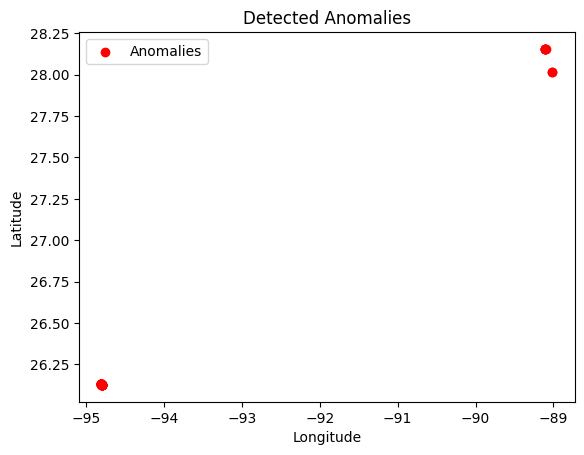

In [18]:
import matplotlib.pyplot as plt

# Plot anomalies on a map (assuming latitude and longitude columns exist)
plt.scatter(anomalous_vessels['LON'], anomalous_vessels['LAT'], c='red', label='Anomalies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Detected Anomalies')
plt.legend()
plt.show()


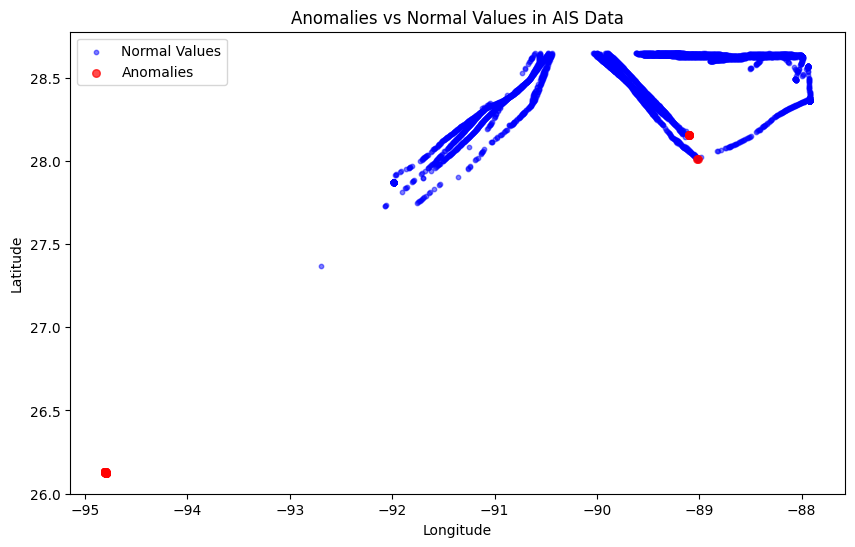

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
vessel_data = pd.read_csv('vessel_data_combined_anomalies.csv')

# Separate anomalies and normal values
anomalies = vessel_data[vessel_data['combined_anomaly_vote'] == 1]
normal_values = vessel_data[vessel_data['combined_anomaly_vote'] == 0]

# Plotting
plt.figure(figsize=(10, 6))

# Plot normal values
plt.scatter(normal_values['LON'], normal_values['LAT'], 
            c='blue', label='Normal Values', alpha=0.5, s=10)

# Plot anomalies
plt.scatter(anomalies['LON'], anomalies['LAT'], 
            c='red', label='Anomalies', alpha=0.7, s=30)

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Anomalies vs Normal Values in AIS Data')
plt.legend()

# Show plot
plt.show()
